In [9]:
import sys
import os
import statistics
import math
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from collections import defaultdict

In [10]:
sys.path.append("..")

In [11]:
from src.data import load_profiles, set_datapath

In [12]:
def get_item_profiles(profile_file: str):
    user_ids, item_ids = set(), set()
    profiles = defaultdict(list)

    with open(profile_file, "r") as df:
        for line in df:
            values = line.strip().split(" ")
            user_id, item_id = int(values[0]), int(values[1])
            user_ids.add(user_id)
            item_ids.add(item_id)
            profiles[item_id].append(user_id)

    return profiles

In [13]:
DATASET = "industrial_and_scientific"
MODE = "all"

In [14]:
os.makedirs(f"../analysis/{DATASET}/{MODE}", exist_ok=True)

In [15]:
set_datapath(f"../../data/{DATASET}")

In [16]:
user_ids, item_ids, user_profiles = load_profiles(f"profiles_{MODE}.txt")
item_profiles = get_item_profiles(f"../../data/{DATASET}/profiles_{MODE}.txt")

In [17]:
edges = set()

for k, v in user_profiles.items():
    for i in v:
        edges.add((k, i))

In [18]:
# Joint statistics
sparsity = len(edges) / (len(user_ids) * len(item_ids)) * 100
interactions = sum(len(p) for p in user_profiles.values())

In [19]:
# User statistics
multi_sess_u = sum(len(p) > 1 for p in user_profiles.values())
avg_u = statistics.mean(len(p) for p in user_profiles.values())
std_u = statistics.stdev(len(p) for p in user_profiles.values())
med_u = statistics.median(len(p) for p in user_profiles.values())
mod_u = statistics.mode(len(p) for p in user_profiles.values())
max_u = max(len(p) for p in user_profiles.values())
min_u = min(len(p) for p in user_profiles.values())

In [20]:
# Item statistics
multi_sess_i = sum(len(p) > 1 for p in item_profiles.values())
avg_i = statistics.mean(len(p) for p in item_profiles.values())
std_i = statistics.stdev(len(p) for p in item_profiles.values())
med_i = statistics.median(len(p) for p in item_profiles.values())
mod_i = statistics.mode(len(p) for p in item_profiles.values())
max_i = max(len(p) for p in item_profiles.values())
min_i = min(len(p) for p in item_profiles.values())

In [21]:
v_labels = list(range(1, 51))
v_counts = [sum(len(p) == i for p in user_profiles.values()) for i in range(1, 51)]

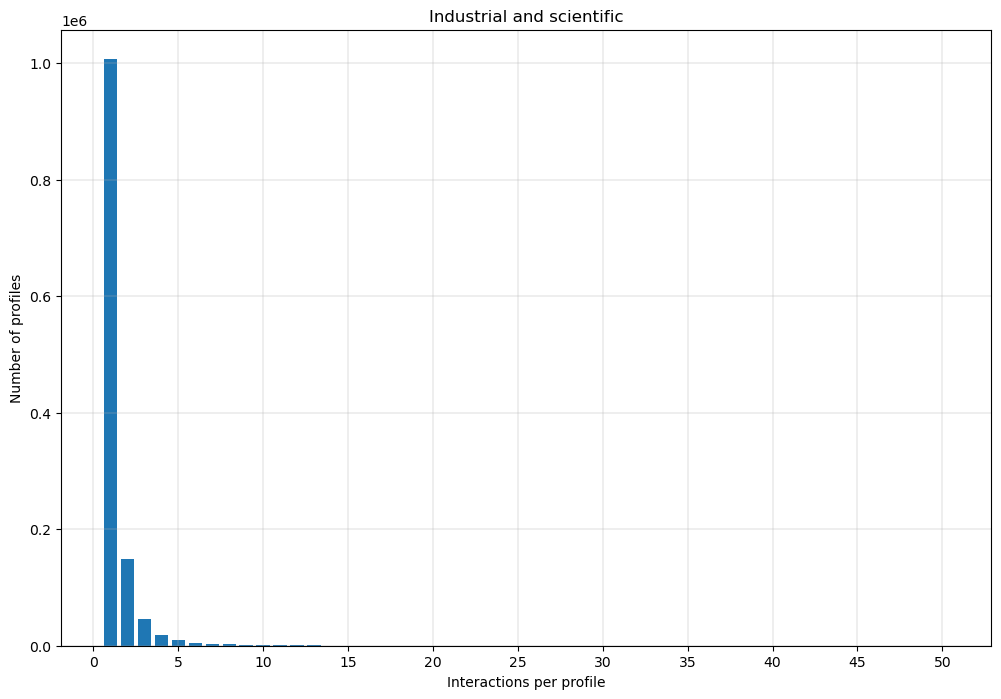

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.bar(v_labels, v_counts)
ax.set(xlabel="Interactions per profile", ylabel="Number of profiles", title=DATASET.replace("_", " ").capitalize())
ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [23]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/user_dist.png")

In [24]:
i_labels = list(range(1, 51))
i_counts = [sum(len(p) == i for p in item_profiles.values()) for i in range(1, 51)]

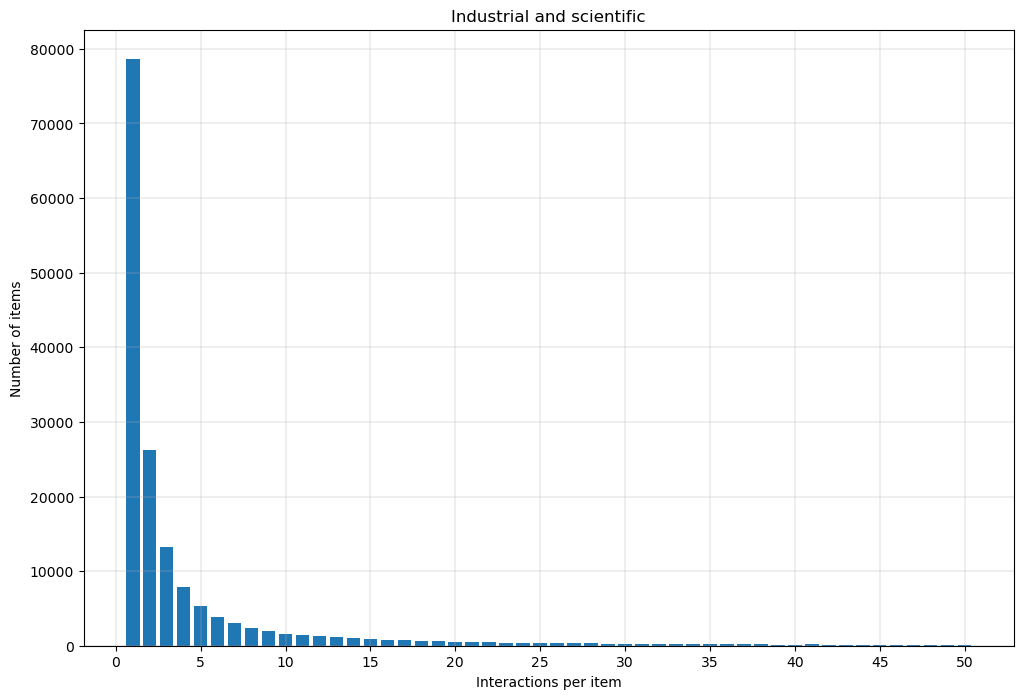

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.bar(i_labels, i_counts)
ax.set(xlabel="Interactions per item", ylabel="Number of items", title=DATASET.replace("_", " ").capitalize())
ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [26]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/item_dist.png")

In [27]:
# Popularity distribution of items
pop = sorted([len(p) for p in item_profiles.values()], reverse=True)

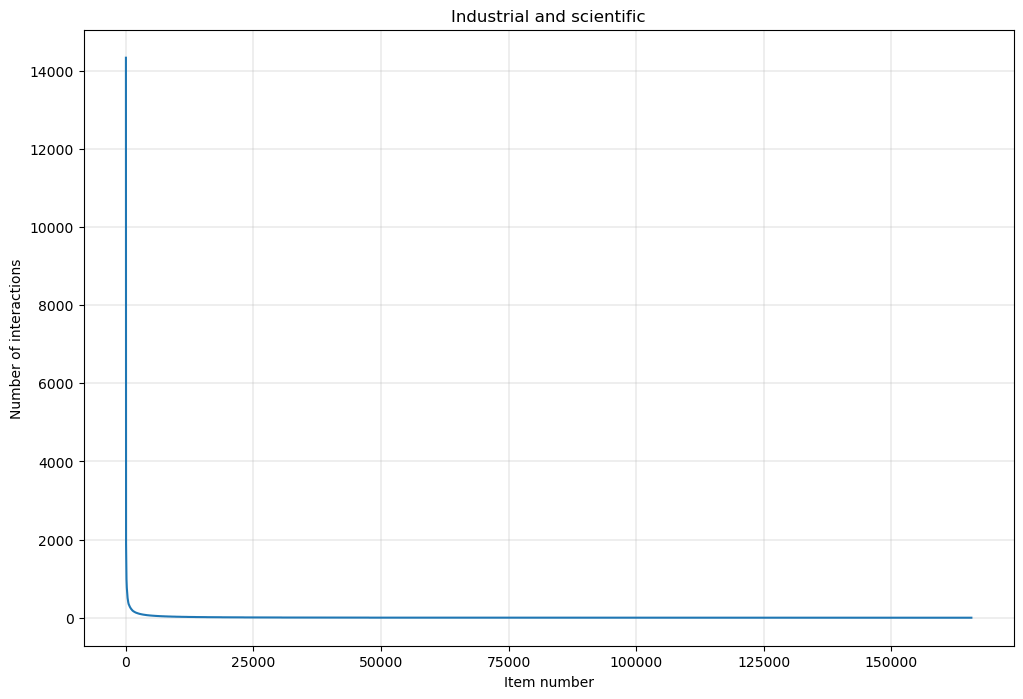

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(range(len(pop)), pop)
ax.set(xlabel="Item number", ylabel="Number of interactions", title=DATASET.replace("_", " ").capitalize())
# ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [29]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/popularity.png")

In [30]:
kvtable = {
    "users": len(user_ids),
    "items": len(item_ids),
    "interactions": interactions,
    "sparsity (%)": round(sparsity, 6),
    "avg_user": round(avg_u, 6),
    "std_user": round(std_u, 6),
    "med_user": med_u,
    "mod_user": mod_u,
    "max_user": max_u,
    "min_user": min_u,
    "avg_item": round(avg_i, 6),
    "std_item": round(std_i, 6),
    "med_item": med_i,
    "mod_item": mod_i,
    "max_item": max_i,
    "min_item": min_i,
}

In [31]:
with open(f"../analysis/{DATASET}/{MODE}/stats.json", "w") as f:
    f.write(json.dumps(kvtable))

In [147]:
id, sbert, onehot = [], [], []

with open(f"../results/{DATASET}/{MODE}/x_identity_id_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        id.append((float(vals[0]), float(vals[1]), int(vals[2])))
with open(f"../results/{DATASET}/{MODE}/sbert_identity_all_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        sbert.append((float(vals[0]), float(vals[1]), int(vals[2])))
with open(f"../results/{DATASET}/{MODE}/onehot_identity_all_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        onehot.append((float(vals[0]), float(vals[1]), int(vals[2])))

In [148]:
merged = []

for t1, t2, t3 in zip(id, sbert, onehot):
    assert t1[2] == t2[2] == t3[2]
    merged.append((t1[2], t1[0], t1[1], t2[0], t2[1], t3[0], t3[1]))

In [149]:
df = pd.DataFrame(merged, columns=["seq_len", "id_HR", "id_NDCG", "sbert_HR", "sbert_NDCG", "onehot_HR", "onehot_NDCG"])

In [150]:
df["bin"] = pd.cut(df["seq_len"], [0, 5, 10, 15, 20, 25, 30])
df_means = df.groupby("bin").agg(["mean", "count", "sum"])
df_means.columns = df_means.columns.map('_'.join)
df_means = df_means.reset_index()

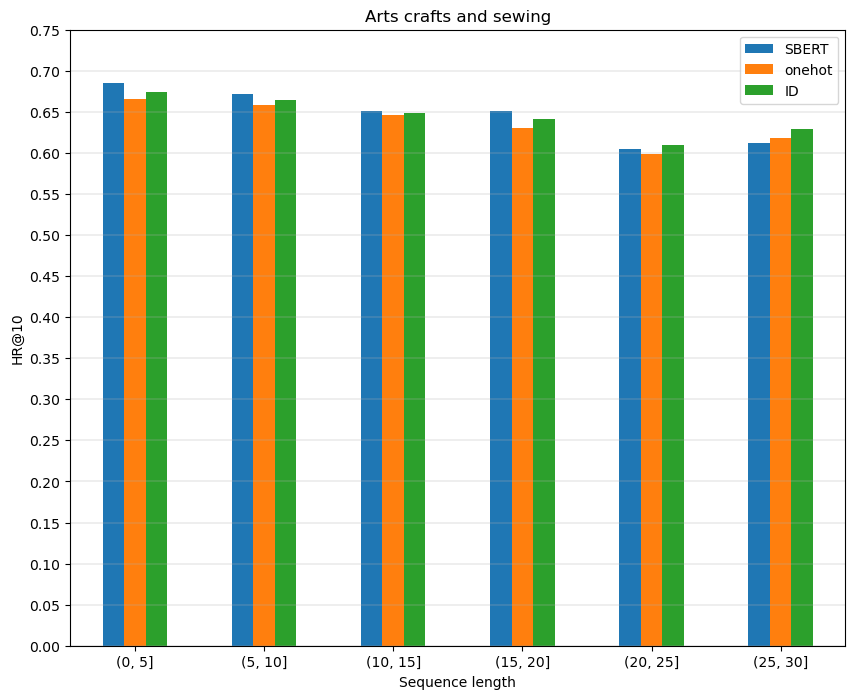

In [153]:
ax = df_means.plot.bar(x="bin", y=["sbert_HR_mean", "onehot_HR_mean", "id_HR_mean"], label=["SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 0.05, 2) for i in range(16)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("HR@10")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [154]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/HR_mean.png")

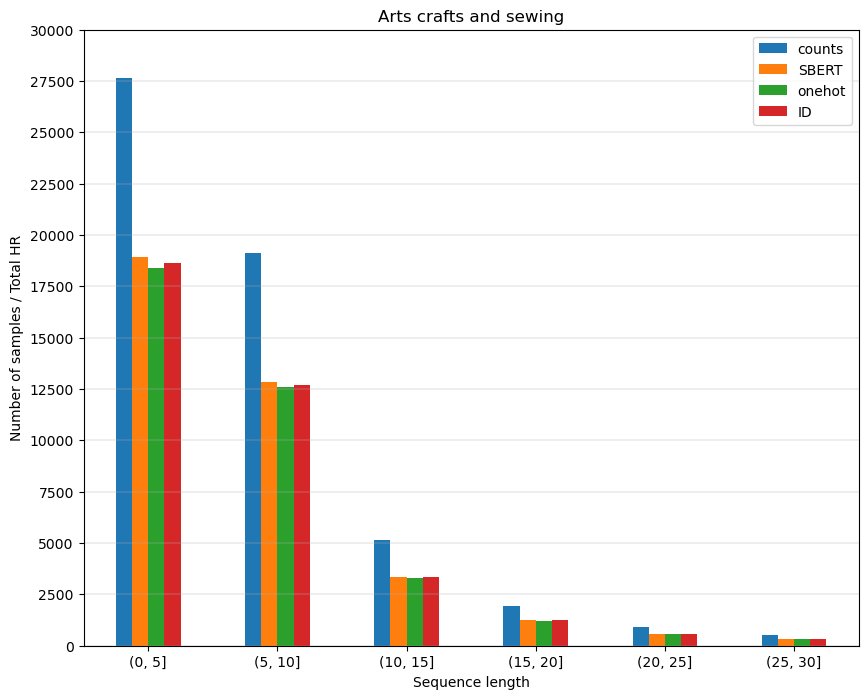

In [158]:
ax = df_means.plot.bar(x="bin", y=["seq_len_count", "sbert_HR_sum", "onehot_HR_sum", "id_HR_sum"], label=["counts", "SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 2500, 0) for i in range(13)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("Number of samples / Total HR")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [159]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/HR_counts.png")

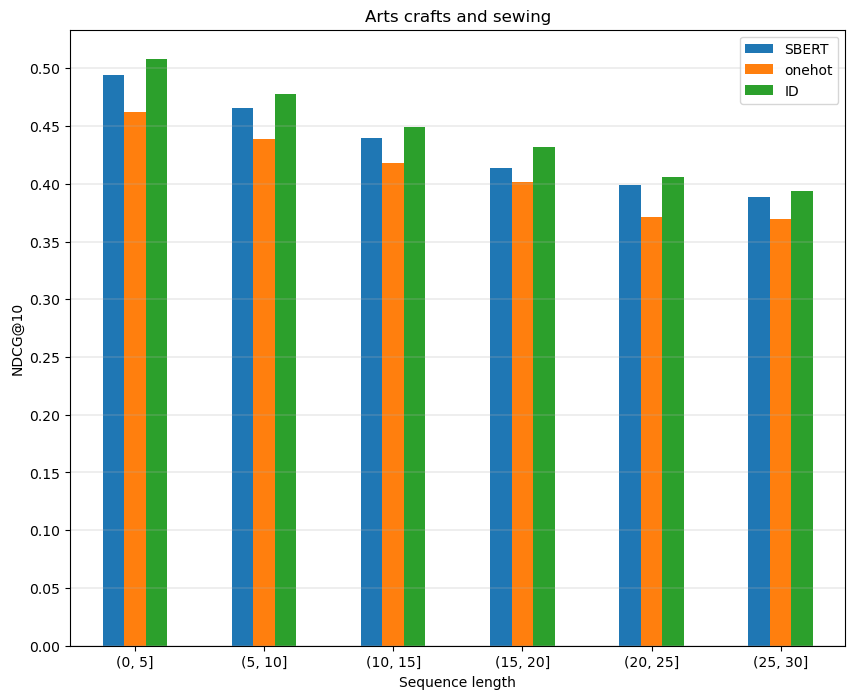

In [162]:
ax = df_means.plot.bar(x="bin", y=["sbert_NDCG_mean", "onehot_NDCG_mean", "id_NDCG_mean"], label=["SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 0.05, 2) for i in range(11)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("NDCG@10")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [163]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/NDCG_mean.png")

In [32]:
table = []

for root, dirnames, filenames in os.walk('../analysis'):
    for fname in [f for f in filenames if f == "stats.json"]:
        with open(os.path.join(root, fname), "r") as src:
            stats = json.loads(src.read())

        parts = root.split("\\")
        name, mode = parts[-2], parts[-1]
        stats = {"name": name, "mode": mode} | stats

        if len(table) == 0:
            table.append(list(stats.keys()))
        
        table.append(list(stats.values()))

In [33]:
result_table = []
result_table.append(table[0].copy() + ["onehot_HR", "onehot_NDCG", "sbert_HR", "sbert_NDCG", "id_HR", "id_NDCG"])
dirs_to_look = ["onehot_identity_all_dot", "sbert_identity_all_dot", "x_identity_id_dot"]

for row in table[1:]:
    name, mode = row[0], row[1]
    basedir = f"../results/{name}/{mode}"
    result_list = []

    for dir in dirs_to_look:
        csv = [f for f in os.listdir(f"{basedir}/{dir}") if f.endswith("csv")]
        assert len(csv) == 1, f"{basedir}/{dir}"

        with open(f"{basedir}/{dir}/{csv[0]}", "r") as src:
            results = src.readlines()
        
        test_results = results[-1].replace("\n", "").split(";")
        assert test_results[2] == "test", f"{basedir}/{dir}/{csv[0]}"

        hr, ndcg = float(test_results[-2]), float(test_results[-1])
        result_list.extend([hr, ndcg])
    
    result_table.append(row.copy() + result_list)

In [34]:
headers = result_table.pop(0)
df = pd.DataFrame(result_table, columns=headers)

In [35]:
df.insert(4, "user_item_ratio", df["users"] / df["items"])

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
df

,name,mode,users,items,user_item_ratio,interactions,sparsity (%),avg_user,std_user,med_user,mod_user,max_user,min_user,avg_item,std_item,med_item,mod_item,max_item,min_item,onehot_HR,onehot_NDCG,sbert_HR,sbert_NDCG,id_HR,id_NDCG
0,arts_crafts_and_sewing,5core,56210,22855,2.459418,492492,0.034165,8.761644,7.050511,7.0,5,215,1,21.548545,58.455496,10.0,5,3859,1,0.6570,0.441582,0.6717,0.473368,0.6589,0.481278
1,arts_crafts_and_sewing,all,1576189,302372,5.212748,2730361,0.000572,1.732255,2.655734,1.0,1,411,1,9.029808,47.454664,2.0,1,4527,1,0.7651,0.564536,0.7742,0.579899,0.6702,0.466127
2,cell_phones,5core,157212,48172,3.263556,1128267,0.014798,7.176723,4.185304,6.0,5,331,3,23.421635,51.746812,10.0,5,1684,1,0.6200,0.411087,0.6247,0.409353,0.6042,0.400923
3,industrial_and_scientific,all,1245370,165682,7.516628,1711934,0.000829,1.374639,1.273459,1.0,1,155,1,10.332649,80.546422,2.0,1,14330,1,0.6527,0.439162,0.6780,0.481360,0.6472,0.430963
4,musical_instruments,5core,27530,10611,2.594477,231312,0.075000,8.402179,6.259680,6.0,5,264,3,21.799265,62.721417,9.0,5,1880,1,0.5709,0.364529,0.5863,0.378337,0.5857,0.390481
5,musical_instruments,all,903050,112128,8.053742,1472323,0.001452,1.630389,2.264143,1.0,1,485,1,13.130735,70.696902,2.0,1,4704,1,0.7301,0.510657,0.7697,0.565896,0.6912,0.475512
6,prime_pantry,all,247640,10812,22.904181,448035,0.016708,1.809219,2.956836,1.0,1,196,1,41.438679,137.248741,15.0,1,6537,1,0.5350,0.305792,0.5594,0.319633,0.5432,0.307681
7,video_games,5core,55223,17389,3.175743,496315,0.049230,8.987469,10.668163,6.0,5,811,2,28.541894,52.238781,13.0,5,1381,1,0.7188,0.486128,0.7278,0.496375,0.7268,0.509420
8,video_games,all,1539731,71908,21.412513,2487867,0.002246,1.615780,2.757771,1.0,1,836,1,34.597917,133.604189,5.0,1,6462,1,0.8224,0.589562,0.8404,0.627944,0.8261,0.630942
9,video_games,sub,597496,55734,10.720494,765738,0.002299,1.281578,1.352003,1.0,1,275,1,13.739154,45.114731,3.0,1,1939,1,0.5787,0.364193,0.6546,0.419799,0.5726,0.353451


In [38]:
df.to_excel("../analysis/stats.xlsx")

Text(0, 0.5, 'SBERT improvement over ID (HR)')

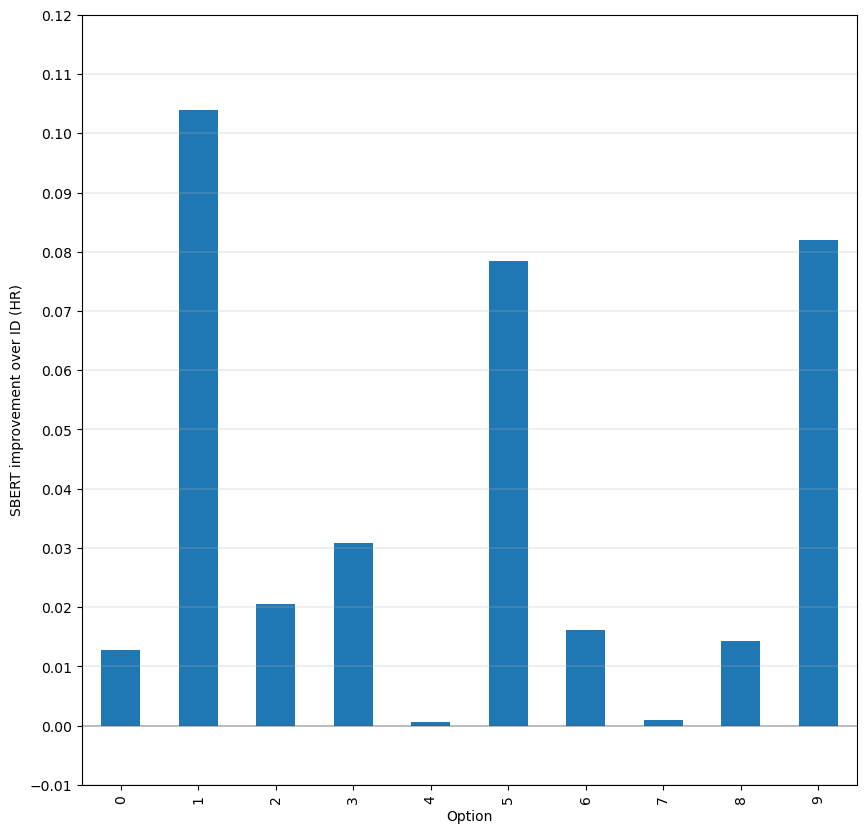

In [39]:
ax = (df["sbert_HR"] - df["id_HR"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over ID (HR)")

In [40]:
ax.get_figure().savefig(f"../analysis/sbert_vs_id_HR.png")

Text(0, 0.5, 'SBERT improvement over ID (NDCG)')

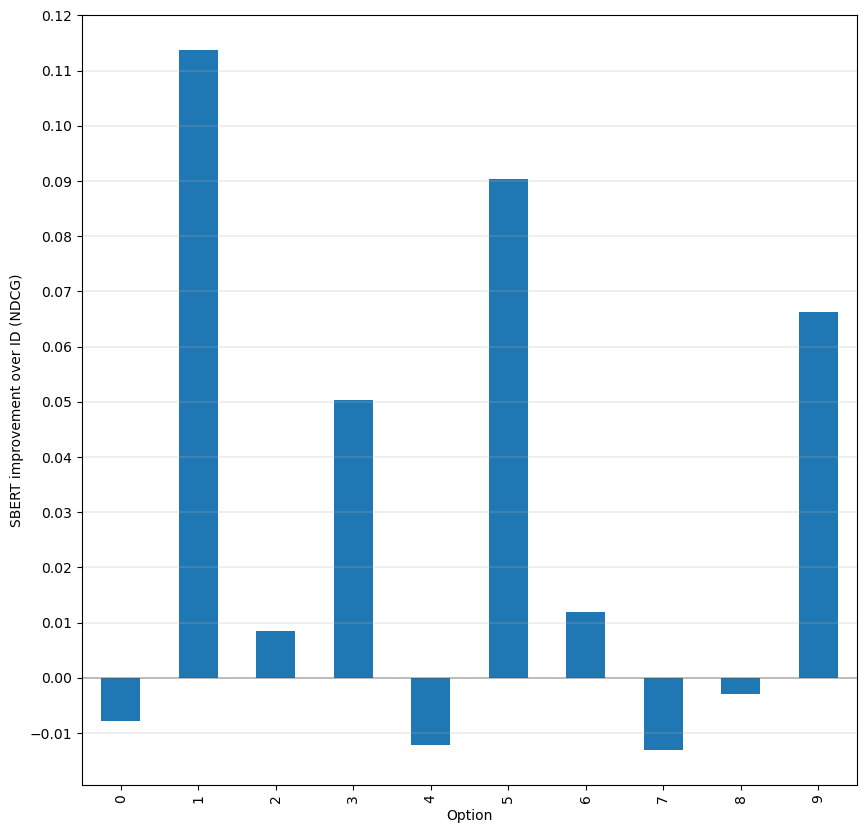

In [41]:
ax = (df["sbert_NDCG"] - df["id_NDCG"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over ID (NDCG)")

In [42]:
ax.get_figure().savefig(f"../analysis/sbert_vs_id_NDCG.png")

Text(0, 0.5, 'SBERT improvement over onehot (HR)')

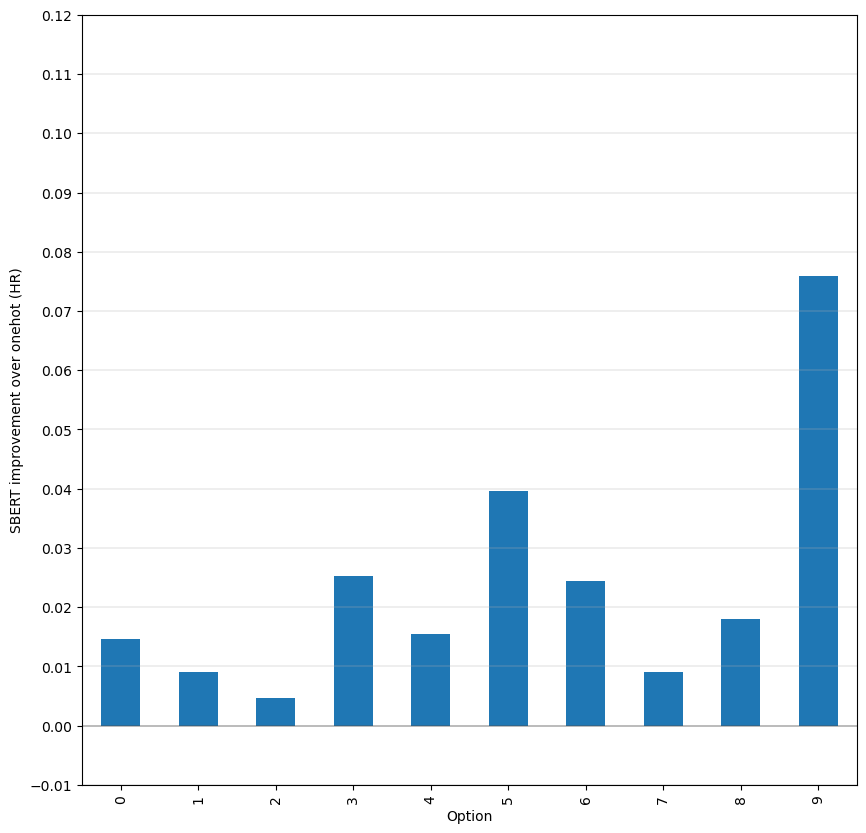

In [43]:
ax = (df["sbert_HR"] - df["onehot_HR"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over onehot (HR)")

In [44]:
ax.get_figure().savefig(f"../analysis/sbert_vs_onehot_HR.png")

Text(0, 0.5, 'SBERT improvement over onehot (NDCG)')

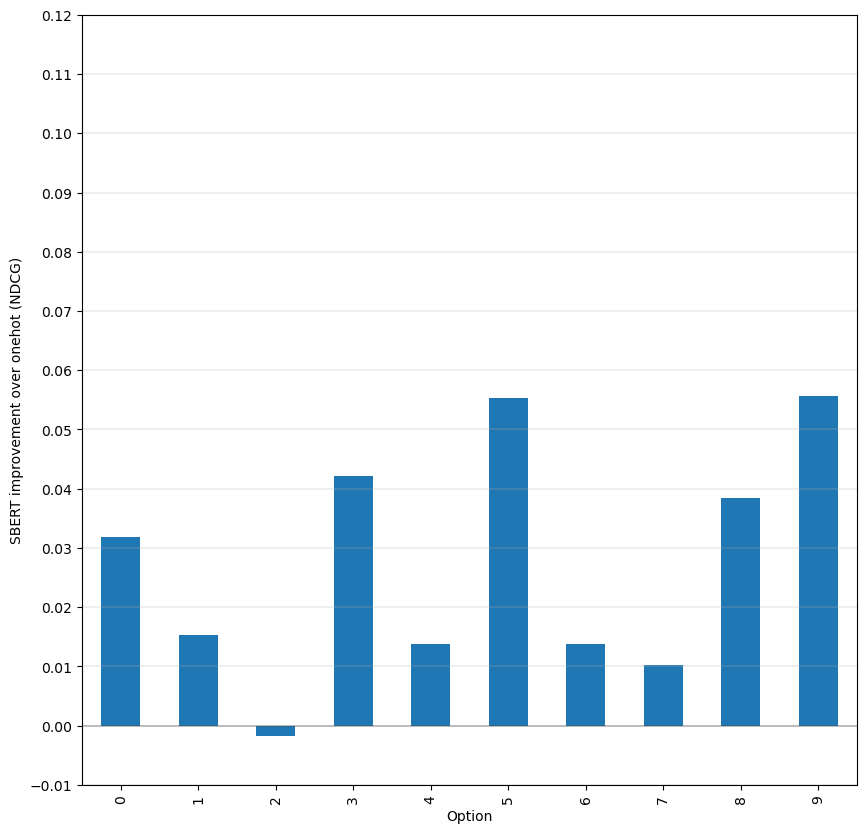

In [45]:
ax = (df["sbert_NDCG"] - df["onehot_NDCG"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over onehot (NDCG)")

In [46]:
ax.get_figure().savefig(f"../analysis/sbert_vs_onehot_NDCG.png")

Text(0, 0.5, 'HR')

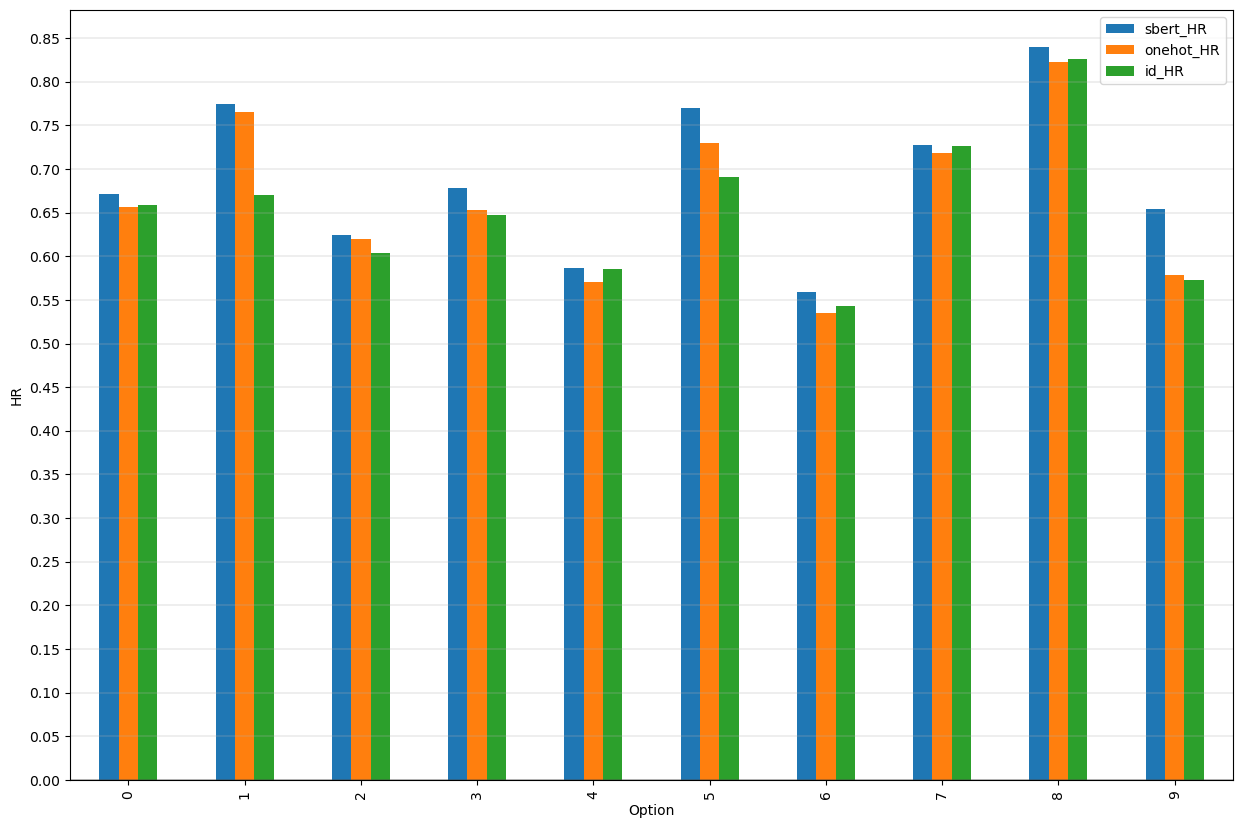

In [47]:
ax = df.reset_index().plot.bar(x="index", y=["sbert_HR", "onehot_HR", "id_HR"], figsize=(15, 10))
ax.set_yticks([round(i * 0.05, 2) for i in range(18)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("HR")

In [48]:
ax.get_figure().savefig(f"../analysis/all_HR.png")

Text(0, 0.5, 'NDCG')

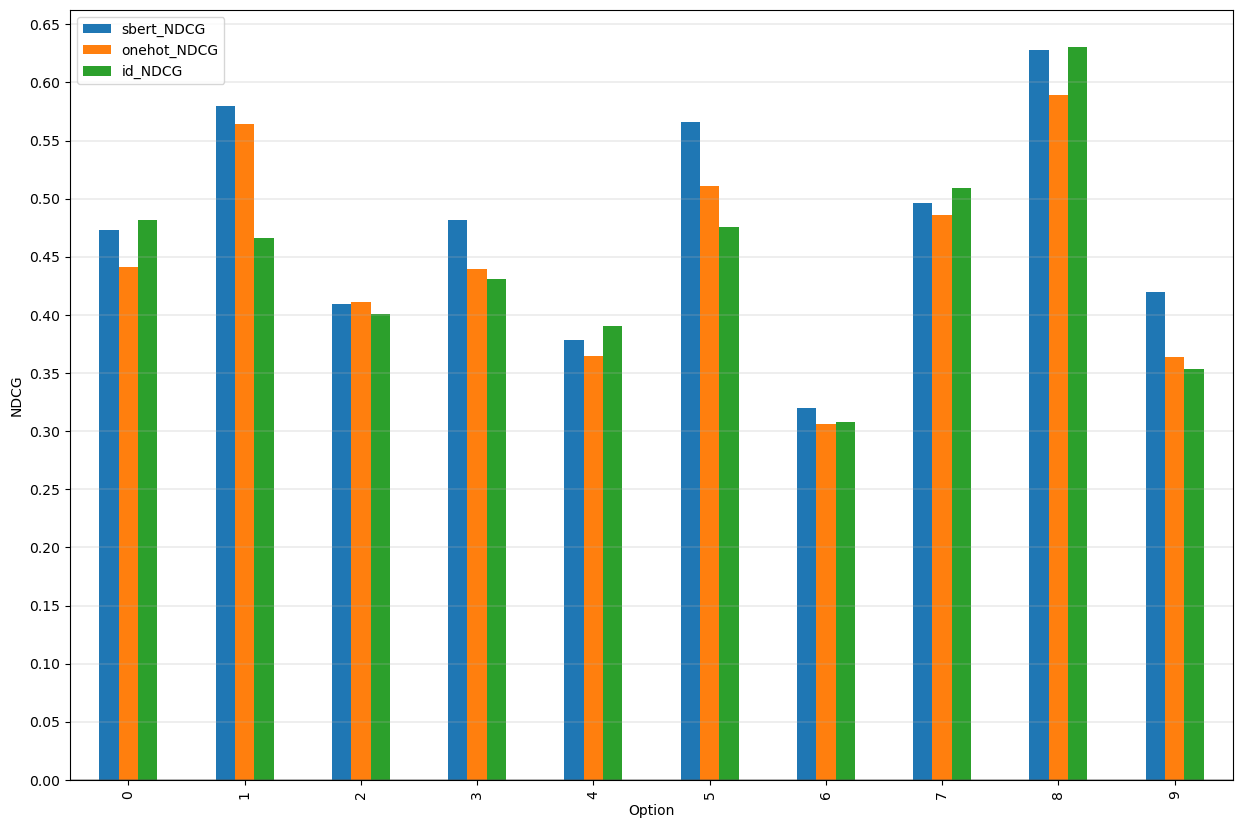

In [49]:
ax = df.reset_index().plot.bar(x="index", y=["sbert_NDCG", "onehot_NDCG", "id_NDCG"], figsize=(15, 10))
ax.set_yticks([round(i * 0.05, 2) for i in range(14)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("NDCG")

In [47]:
ax.get_figure().savefig(f"../analysis/all_NDCG.png")